In [4]:
%matplotlib notebook
import numpy as np
import scipy.io as io
import sounddevice as sd
import scipy.signal as signal
import matplotlib.pyplot as pyplot
import numpy.fft as fft
import random
import numpy.random as npRand
import time

In [5]:
def spectogram(x, fs, win, winLen, overlap):
    f, t, Xft = signal.stft(x, fs, win, winLen, overlap)
    pyplot.figure()
    pyplot.pcolormesh(1000 * t, f, np.abs(Xft))
    
def loadMatSound(filename):
    return io.loadmat(filename)[filename.replace(".mat", "")][:, 0]

def genTones(tones, duration):
    Fs = 8000
    samples = round(Fs * duration)
    n = np.arange(samples)
    result = np.zeros(samples)
    
    for tone in tones:
        result += np.cos(2 * np.pi * tone * n / Fs)
        
    return result

replaceZeroes = np.vectorize(lambda t: 10 ** (-10) if t == 0 else t)

def plot_spectrum_t(x, fs, win, winLen, overlap, tPoint):
    f, t, Xft = signal.stft(x, fs, win, winLen, overlap)
    
    timeIndex = None
    highFreqI = None
    lowFreqI = None
    
    for i, ti in enumerate(t):
        if tPoint <= ti:
            timeIndex = i
            break
            
    for i, fi in enumerate(f):
        
        if lowFreqI is None and fi >= 650:
            lowFreqI = i
            
        if highFreqI is None and fi >= 1650:
            highFreqI = i
        
        if lowFreqI is not None and highFreqI is not None:
            break
    
    timeIndex = timeIndex if t[timeIndex] - tPoint < tPoint - t[timeIndex - 1] \
    else timeIndex - 1
     
    pyplot.figure()
    pyplot.title(f"t = {tPoint}")
    pyplot.plot(f[lowFreqI:highFreqI], np.abs(Xft[lowFreqI:highFreqI, timeIndex]))
            
dtmfTable = {
    1:(697, 1209),
    2:(697, 1336),
    3:(697, 1477),
    "A":(697, 1633),
    4:(770, 1209),
    5:(770, 1336),
    6:(770, 1477),
    "B":(770, 1633),
    7:(852, 1209),
    8:(852, 1336),
    9:(852, 1477),
    "C":(852, 1633),
    "*":(941, 1209),
    0:(941, 1336),
    "#":(941, 1477),  
    "D":(941, 1633)
}

def dtmfEncoder(keys, toneDuration, silenceDuration):
    Fs = 8000
    result = None
    silence = np.zeros(round(Fs * silenceDuration))
    for key in keys:
        t = genTones(dtmfTable[key], toneDuration)
        if result is None:
            result = t
        else:
            result = np.concatenate((result, silence, t))
            
            
    return result

<IPython.core.display.Javascript object>


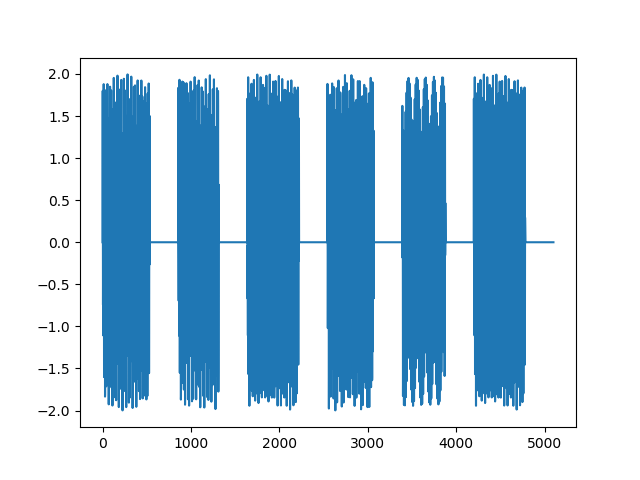

<IPython.core.display.Javascript object>


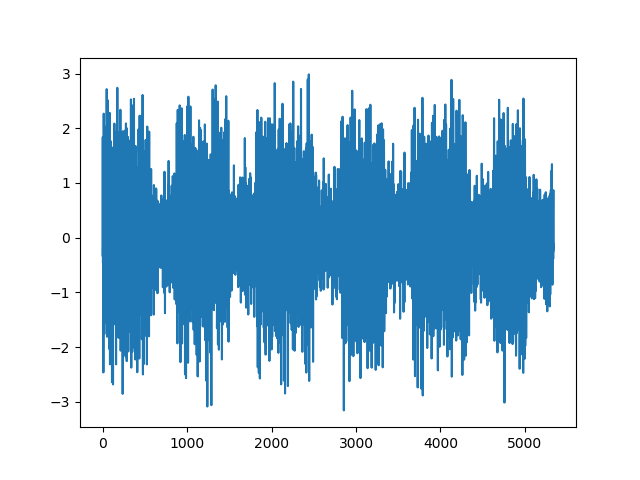

<IPython.core.display.Javascript object>


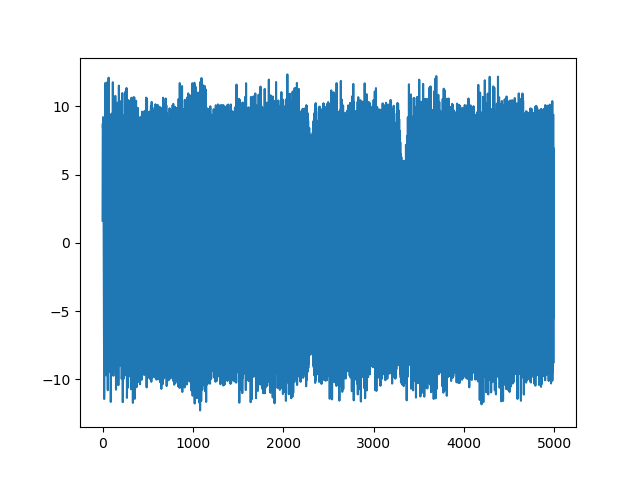

In [6]:
dtmf1 = loadMatSound("dtmf1.mat") # 519439
dtmf2 = loadMatSound("dtmf2.mat") # 221840
dtmf3 = loadMatSound("dtmf3.mat") # 721164
pyplot.figure()
pyplot.plot(dtmf1)
pyplot.figure()
pyplot.plot(dtmf2)
pyplot.figure()
pyplot.plot(dtmf3)
sd.play(dtmf2, 8000)

<IPython.core.display.Javascript object>


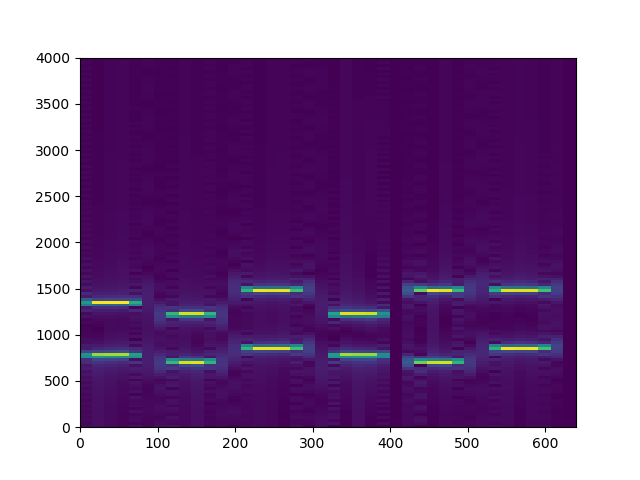

In [19]:
Fs = 8000
spectogram(dtmf1, Fs, "boxcar", 256, 128)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.46)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.18)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.407)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.36)

#spectogram(dtmf1, Fs, "boxcar", 2, 0)

<IPython.core.display.Javascript object>


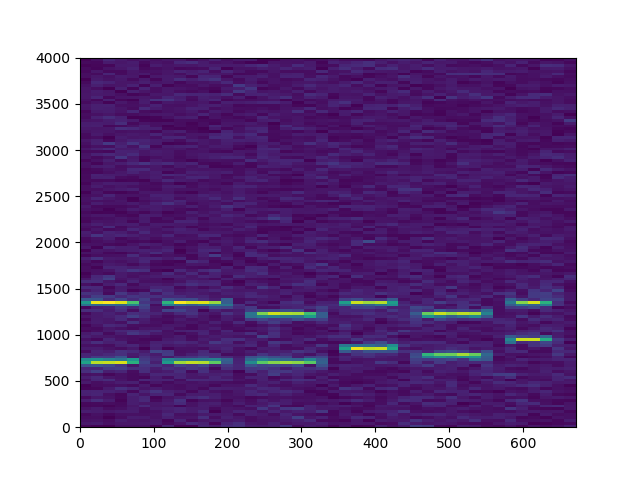

In [5]:
spectogram(dtmf2, Fs, "boxcar", 256, 128)

<IPython.core.display.Javascript object>


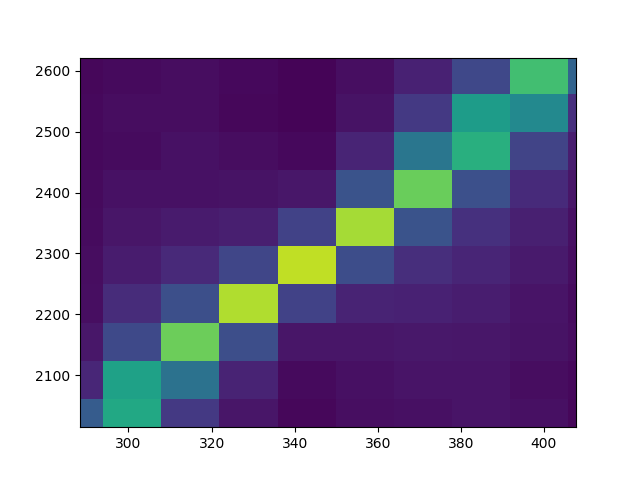

In [20]:
spectogram(dtmf3, Fs, "boxcar", 128, 16)

In [9]:
class DTMF:
    
    dtmfTable = {
    1:(697, 1209),
    2:(697, 1336),
    3:(697, 1477),
    "A":(697, 1633),
    4:(770, 1209),
    5:(770, 1336),
    6:(770, 1477),
    "B":(770, 1633),
    7:(852, 1209),
    8:(852, 1336),
    9:(852, 1477),
    "C":(852, 1633),
    "*":(941, 1209),
    0:(941, 1336),
    "#":(941, 1477),  
    "D":(941, 1633)
    }
    
    def __init__(self, minToneDuration = 0.04):
        self._keys = {}
        self._minToneDuration = minToneDuration
        for key in DTMF.dtmfTable:
            toneFft = fft.rfft(DTMF.genToneKey(DTMF.dtmfTable[key], 256), 256)
            toneFft = np.abs(toneFft) / np.amax(np.abs(toneFft))
            maxSim  = np.dot(toneFft, toneFft)
            self._keys[key] = (toneFft, maxSim) 
    
    def decode(self, x):
        freq, time, Zxx = signal.stft(x, 8000, "boxcar", 256, 128)
        keys = []
        timeAppeared = None
        lastKey = None
        Zxx = (np.abs(Zxx) / np.amax(np.abs(Zxx))).T
        for fftColumn, t in zip(Zxx, time):
            currKey = self.getKeyForFFT(fftColumn)
            #print(currKey)
            if lastKey is None and currKey is not None:
                timeAppeared = t
                lastKey = currKey
            elif lastKey != currKey:
                if t - timeAppeared > self._minToneDuration:
                    keys.append(lastKey)
                lastKey = currKey
                timeAppeared = t
                
        if lastKey != None and time[-1] - timeAppeared > self._minToneDuration:
            keys.append(lastKey)
            
        return keys
            
    def getKeyForFFT(self, fftColumn):
        similarity = {}
        for key, fftSimPair in self._keys.items():
            similarity[key] = np.dot(fftColumn, fftSimPair[0])
        
        # List of tuples of shape (key, similarity)
        result = sorted(similarity.items(), key = lambda keyValue: keyValue[1], reverse = True)
        
        #print(f"{result[0][0]} {result[0][1]}")
        decodedKey, sim = result[0][0], result[0][1]
           
        return decodedKey if sim > 0.5 * self._keys[decodedKey][1] else None
            
        
    @staticmethod
    def genToneKey(freqs, samples):
        Fs = 8000
        n = np.arange(samples)
        result = np.zeros(samples)
    
        for freq in freqs:
             result += np.cos(2 * np.pi * freq * n / Fs)
        
        return result
    

In [10]:
class DTMF2:
    
    dtmfTable = {
    (697, 1209): 1,
    (697, 1336): 2,
    (697, 1477): 3,
    (697, 1633): "A",
    (770, 1209): 4,
    (770, 1336): 5,
    (770, 1477): 6,
    (770, 1633): "B",
    (852, 1209): 7,
    (852, 1336): 8,
    (852, 1477): 9,
    (852, 1633): "C",
    (941, 1209): "*",
    (941, 1336): 0,
    (941, 1477): "#",  
    (941, 1633): "D"
    }
    
    
    def __init__(self, minToneDuration = 0.04):
        self._lowFreqs = {x: None for x in (697, 770, 852,941)}
        self._highFreqs = {x: None for x in (1209, 1336, 1477, 1633)}
        
        self._minToneDuration = minToneDuration
        for freq in self._lowFreqs:
            toneFft = fft.rfft(DTMF2.genTone((freq,), 256), 256)
            toneFft = np.abs(toneFft) / np.amax(np.abs(toneFft))
            maxSim  = np.dot(toneFft, toneFft)
            self._lowFreqs[freq] = (toneFft, maxSim) 
            
        for freq in self._highFreqs:
            toneFft = fft.rfft(DTMF2.genTone((freq,), 256), 256)
            toneFft = np.abs(toneFft) / np.amax(np.abs(toneFft))
            maxSim  = np.dot(toneFft, toneFft)
            self._highFreqs[freq] = (toneFft, maxSim)
            
        
    def decode(self, x):
        freq, time, Zxx = signal.stft(x, 8000, "boxcar", 256, 128)
        keys = []
        timeAppeared = None
        lastKey = None
        Zxx = (np.abs(Zxx) / np.amax(np.abs(Zxx))).T
        for fftColumn, t in zip(Zxx, time):
            currKey = self.getKeyForFFT(fftColumn, freq)
            #print(currKey)
            if lastKey is None and currKey is not None:
                timeAppeared = t
                lastKey = currKey
            elif lastKey != currKey:
                if t - timeAppeared > self._minToneDuration:
                    keys.append(lastKey)
                lastKey = currKey
                timeAppeared = t
                
        if lastKey != None and time[-1] - timeAppeared > self._minToneDuration:
            keys.append(lastKey)
            
        return keys
            
    def getKeyForFFT(self, fftColumn, freqs):
        lowFreq = self.getFreqForFFT(self._lowFreqs, fftColumn)
        if lowFreq is None:
            return None
        highFreq = self.getFreqForFFT(self._highFreqs, fftColumn)
        if highFreq is None:
            return None
        
        decodedValue = DTMF2.dtmfTable[(lowFreq, highFreq)]
        return decodedValue
    
    def getFreqForFFT(self, freqs, fftColumn):
        similarity = {}
        for freq, fftSimPair in freqs.items():
            similarity[freq] = np.dot(fftColumn, fftSimPair[0])
            
        result = sorted(similarity.items(), key = lambda keyValue: keyValue[1], reverse = True)
        #print(result)
        matchedFreq, sim = result[0][0], result[0][1]
        
        return matchedFreq if sim > 0.5 * freqs[matchedFreq][1] else None
    
    @staticmethod
    def genTone(freqs, samples):
        Fs = 8000
        n = np.arange(samples)
        result = np.zeros(samples)
    
        for freq in freqs:
             result += np.cos(2 * np.pi * freq * n / Fs)
        
        return result
    

In [12]:
dtmf = DTMF2(0.03)
print(dtmf.decode(dtmf1))
print(dtmf.decode(dtmf2))
result = dtmfEncoder([6, "*"], 0.04, 0.01)
print(dtmf.decode(result))

[5, 1, 9, 4, 3, 9]
[2, 2, 1, 8, 4, 0]
[6, '*']


In [69]:
dtmf = DTMF2(0.03)
decodedCount = 0 # Num of succesful decoding
toDecode = 10000
decodeTime = 0
for n in range(toDecode):
    seq = random.choices(list(dtmfTable.keys()), k = 6)
    toneDuration = random.uniform(0.04, 0.1)
    encodedSeq = dtmfEncoder(seq, 0.04, 0.04)
    encodedSeq = encodedSeq + npRand.normal(0, 0.5477 ** 0.5, len(encodedSeq))
    startTime = time.perf_counter_ns()
    decodedSeq = dtmf.decode(encodedSeq)
    endTime = time.perf_counter_ns()
    decodeTime += endTime - startTime
    if seq != decodedSeq:
        print("Dekodovanje nije uspijelo")
        print(f"Dekodovano: {decodedSeq}, Enkodovano: {seq}")
        print(f"Trajanje tona: {toneDuration}")
    else:
        decodedCount += 1
print(f"Broj uspjesnih dekodovanja: {decodedCount}")
print(f"Broj neuspjesnih dekodovanja {toDecode - decodedCount}")
print(f"Procenat uspjesnosti: {decodedCount * 100 / toDecode}")
decodePerSec = decodedCount * 10 ** 9 / decodeTime
print(f"Broj dekodovanja u sekundi: {round(decodePerSec)}")
print(f"Trajanje jednog dekodovanja(u ms): {1000 / decodePerSec}")

Broj uspjesnih dekodovanja: 10000
Broj neuspjesnih dekodovanja 0
Procenat uspjesnosti: 100.0
Broj dekodovanja u sekundi: 1801
Trajanje jednog dekodovanja(u ms): 0.5552893400000001


<IPython.core.display.Javascript object>


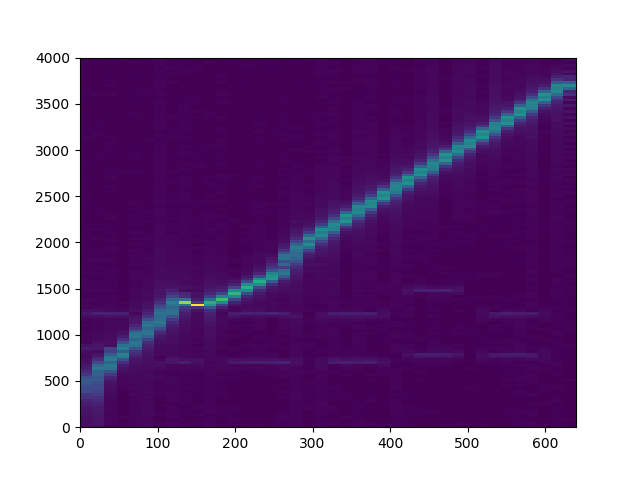

<IPython.core.display.Javascript object>


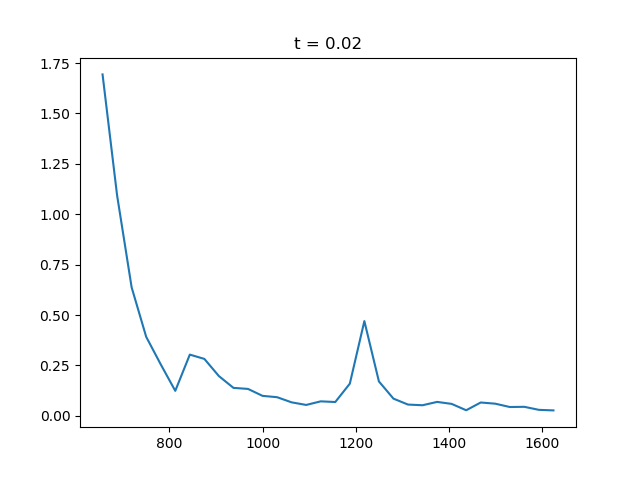

<IPython.core.display.Javascript object>


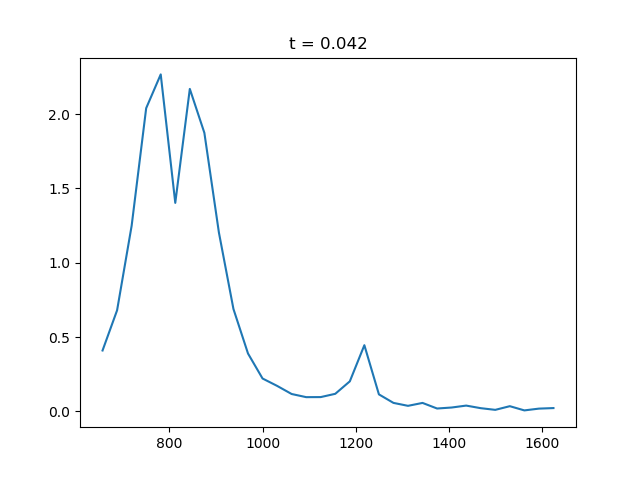

<IPython.core.display.Javascript object>


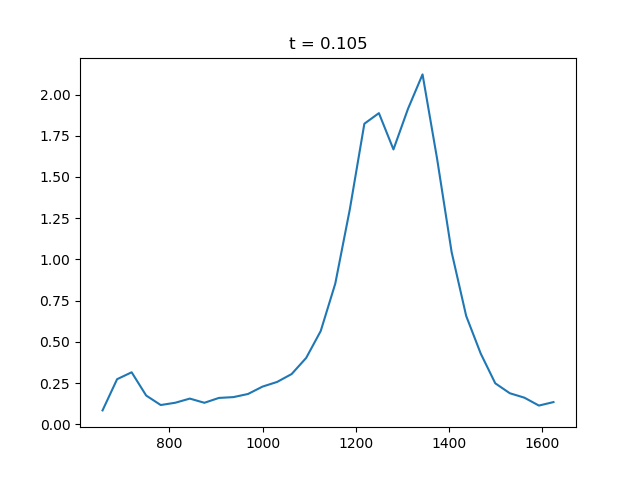

<IPython.core.display.Javascript object>


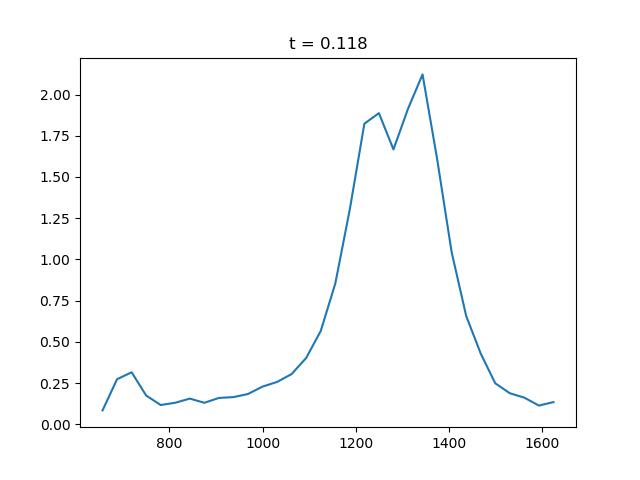

<IPython.core.display.Javascript object>


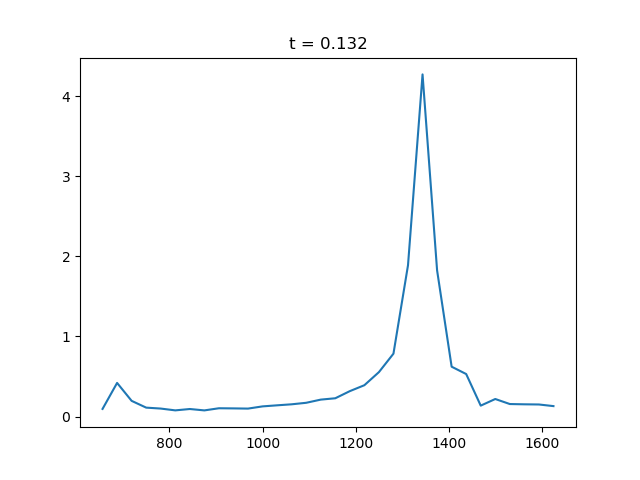

<IPython.core.display.Javascript object>


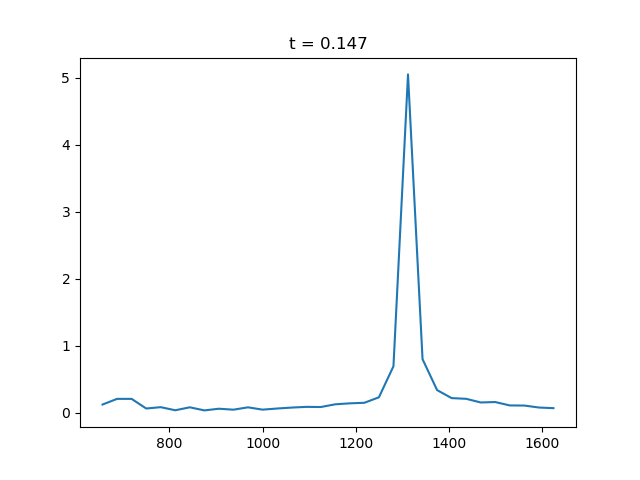

<IPython.core.display.Javascript object>


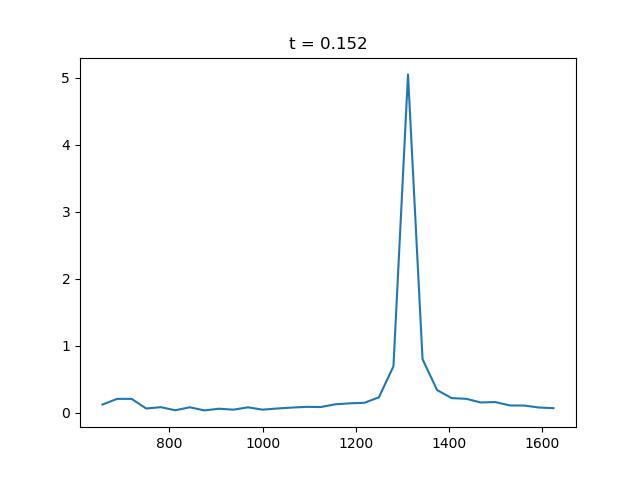

<IPython.core.display.Javascript object>


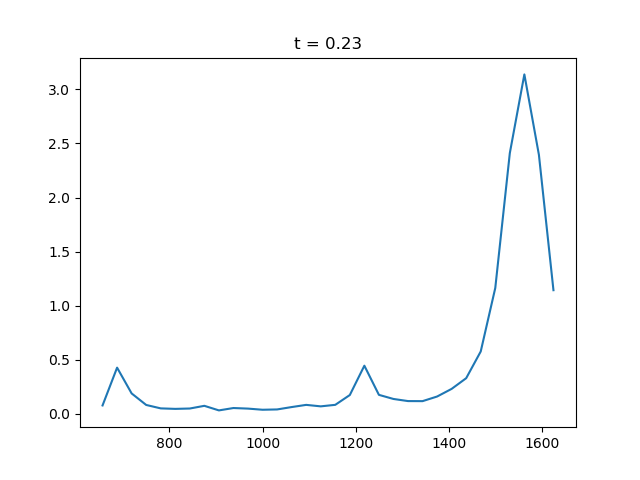

In [68]:
spectogram(dtmf3, 8000, "boxcar", 256, 128)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.020)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.042)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.105)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.118)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.132)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.147)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.152)
plot_spectrum_t(dtmf3, 8000, "boxcar", 256, 128, 0.230)

<IPython.core.display.Javascript object>


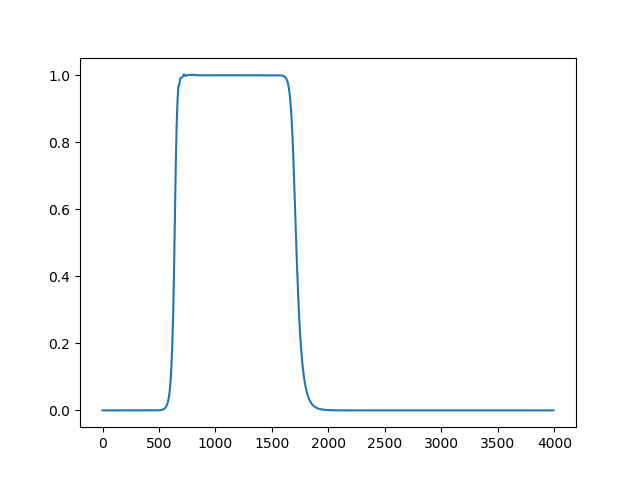

<IPython.core.display.Javascript object>


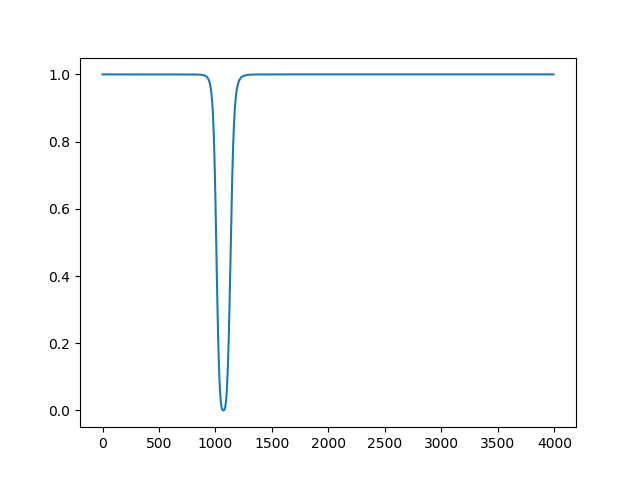

<IPython.core.display.Javascript object>


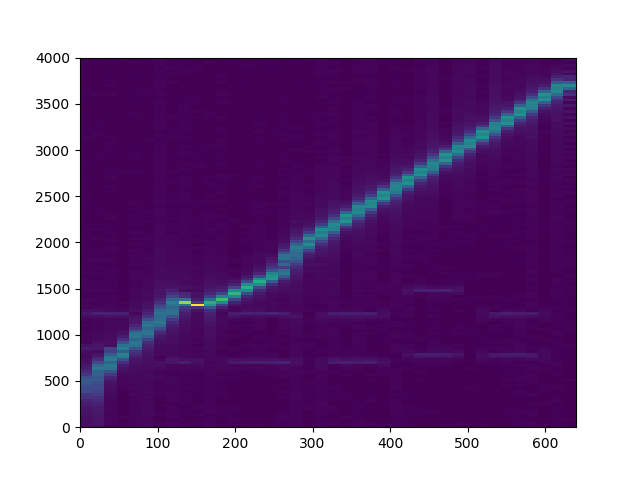

<IPython.core.display.Javascript object>


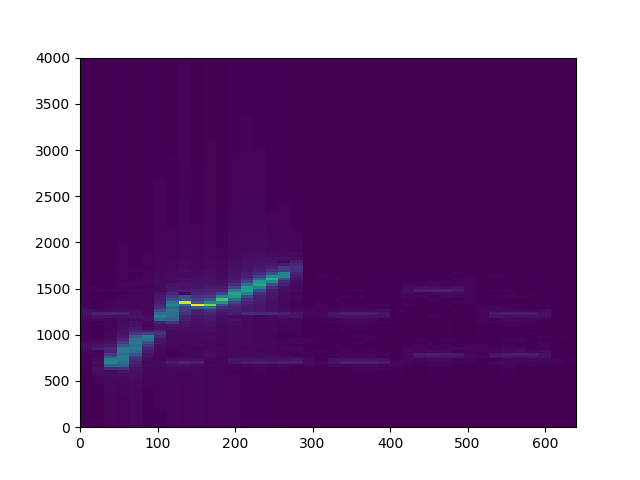

<IPython.core.display.Javascript object>


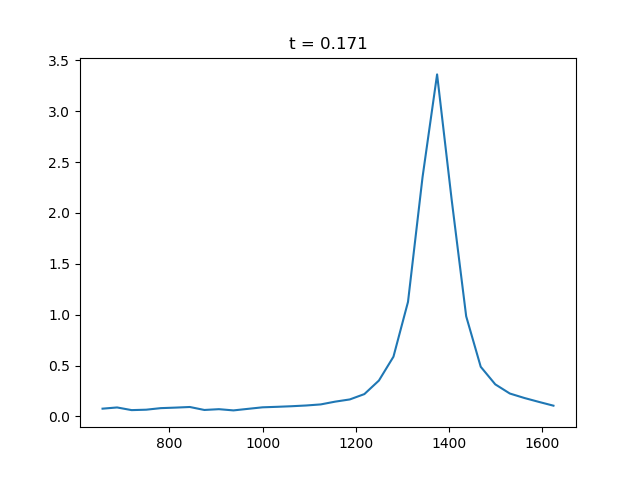

In [67]:
order, wn = signal.buttord([660, 1670], [600, 1790], 1, 20, fs = 8000)
b1, a1 = signal.butter(order, wn, "bandpass", fs = 8000)
w, H = signal.freqz(b1, a1, fs = 8000)
pyplot.figure()
pyplot.plot(w, np.abs(H))

order, wn = signal.buttord([970, 1170], [1040, 1100], 1, 20, fs = 8000)
b2, a2 = signal.butter(order, wn, "bandstop", fs = 8000)
w, H = signal.freqz(b2, a2, fs = 8000)
pyplot.figure()
pyplot.plot(w, np.abs(H))

dtmf3Filt = signal.lfilter(b1, a1, dtmf3)
dtmf3Filt = signal.lfilter(b2, a2, dtmf3Filt)
spectogram(dtmf3, 8000, "boxcar", 256, 128)
spectogram(dtmf3Filt, 8000, "boxcar", 256, 128)
plot_spectrum_t(dtmf3Filt, 8000, "boxcar", 256, 128, 0.171)

<IPython.core.display.Javascript object>


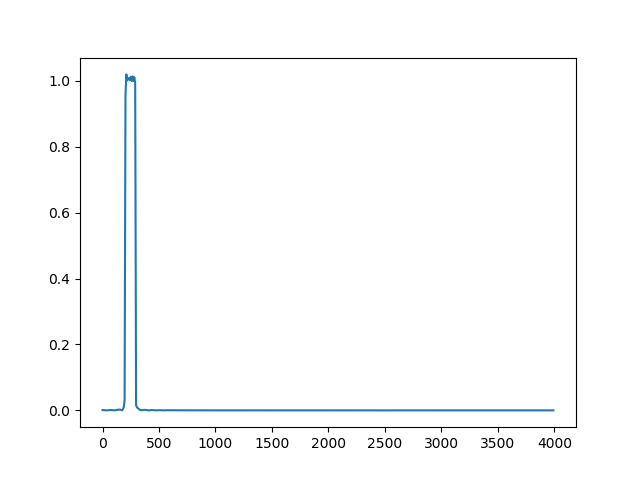

In [77]:
h = signal.firwin(5001, [200, 290], window = "boxcar", pass_zero = False, fs = 8000)
w, H = signal.freqz(h, 1, fs = 8000)
pyplot.figure()
pyplot.plot(w, np.abs(H))